# Intrinsic/Extrinsic Parameter estimation

국민대학교 차량지능특론 SLAM 파트 과제 3

- 학번 : A2021019
- 이름 : 김태산

---

OpenCV를 사용해 여러 장의 체스 보드 이미지에 대한 카메라의 내부/외부 파라미터를 구한다.

---

**[중요] 과제 제출 방법**
- 과제 제출 기한은 2021년 6월 9일까지입니다.
- 과제는 Colab에서 작성한 것을 다운받아 (파일-.ipynb 다운로드) 가상 대학에 업로드합니다. (이외의 제출 방법은 인정하지 않음)
- 제출 시 파일 제목은 '학번_이름' 으로 저장합니다.

In [ ]:
import sys
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

print('python', sys.version)
print('numpy', np.__version__)
print('opencv', cv.__version__)

python 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
numpy 1.19.5
opencv 4.1.2


## Google Drive와 연동하기


In [ ]:
# mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls '/content/drive/My Drive/Colab Notebooks/Vehicle Intelligence/img/calib/'

left01.jpg  left05.jpg	left09.jpg  left14.jpg	 test03.jpg  test07.jpg
left02.jpg  left06.jpg	left11.jpg  pattern.png  test04.jpg  test08.jpg
left03.jpg  left07.jpg	left12.jpg  test01.jpg	 test05.jpg  test09.jpg
left04.jpg  left08.jpg	left13.jpg  test02.jpg	 test06.jpg  test10.jpg


In [ ]:
ROOT = '/content/drive/My Drive/Colab Notebooks/Vehicle Intelligence/img/calib/'

### 이미지 불러오기

좋은 결과를 위해 최소 10장의 사진이 준비되어야 한다.

13


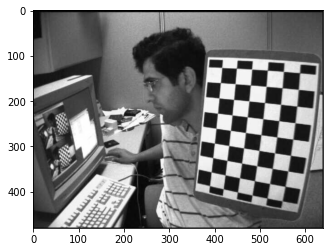

In [ ]:
images = []
image_files = glob.glob(ROOT + 'left*.jpg')
for f in image_files :
  img = cv.imread(f)
  images.append(img)

print(len(images))
plt.imshow(images[0][:,:,::-1])
plt.show()

## 체스 보드 코너 찾기




관련 함수

- `	retval, corners	=	cv.findChessboardCorners(	image, patternSize[, corners[, flags]]	)`
- `corners	=	cv.cornerSubPix(	image, corners, winSize, zeroZone, criteria)`
- `	image	=	cv.drawChessboardCorners(	image, patternSize, corners, patternWasFound	)`



**과제**

- 관련 함수들에 대한 입력과 출력, 파라미터를 조사해 서술한다.
- 관련 함수들을 사용하여 체스 보드의 코너를 찾는 함수 `findCorner()`를 완성한다. `findCorner()` 함수의 입력과 출력은 다음과 같다.
  - 입력 : 코너를 찾을 체스 보드의 이미지
  - 출력
    - ret : 함수의 성공 여부
    - corner_refine : `cv.cornerSubPix()`를 통해 개선된 코너점
    - corner_img : 찾은 코너와 원본 이미지를 합성한 이미지


**참고**

- 주어진 체스 보드는 9x6 grid이다.
---
### 1. 관련 함수들에 대한 입력과, 출력, 파라미터를 조사해 서술한다.
`	retval, corners	=	cv.findChessboardCorners(	image, patternSize[, corners[, flags]]	)`  
- cv.findChessboardCorners()는 입력 이미지에 체스보드 패턴이 있는지를 찾고, 체스보드 상의 내부 코너점들을 추출하여 해당 코너점들의 좌표를 리턴해주는 함수이다.
- 입력
  1. image: 체스보드가 포함되어 있는 이미지. 8비트의 그레이스케일 또는 컬러 이미지를 입력한다.
- 출력
  1. retval: 함수 실행 성공 여부를 알려주는 변수로, 체스보드 상의 모든 코너점들을 찾은 후 위치 좌표까지 구했을 경우 0이 아닌 값을 리턴하고, 모든 코너점들을 찾지 못한 경우 0을 리턴한다.
  2. corners: 함수를 통해 구한 체스보드 내부 코너점들의 위치 좌표값들이 입력된다.
- 파라미터
  1. patternSize: 체스보드의 행과 열에 있는 내부 코너점의 갯수를 설정한다.
  2. corners: 추출된 코너점들의 출력 배열이 리턴된다.
  3. flags: flag 파라미터를 통해 아래와 같은 다양한 설정을 할 수 있다.
    - CALIB_CB_ADAPTIVE_THRESH: 이미지를 컬러에서 흑백으로 변환할 때 이미지의 밝기에 대한 평균값으로부터 계산된 가변적인 threshold를 적용한다.
    - CALIB_CB_NORMALIZE_IMAGE: Threshold를 적용하기 전에 equalizeHist를 통해 이미지의 gamma를 정규화한다.
    - CALIB_CB_FILTER_QUADS: 경계선 검출 단계에서 잘못된 quad들을 필터링하여 제거하기 위해 추가적인 조건들(경계선 영역, 둘레 등)을 적용한다.
    - CALIB_CB_FAST_CHECK: Fast check을 통해 입력된 이미지에 체스보드가 있는지의 여부를 먼저 판단하여 체스보드가 인식되지 않는 경우 call을 한다. 이를 통해 체스보드가 이미지에 없을 때 함수의 실행 속도를 크게 높일 수 있다.

`corners	=	cv.cornerSubPix(	image, corners, winSize, zeroZone, criteria)`
- cv.cornerSubPix()는 cv.findChessboardCorners()에 의해 추출된 코너점들의 대략적인 위치 좌표를 더 정확하게 보정해주는 함수이다.
- 입력
  1. image: 체스보드가 포함되어 있는 이미지. cv.findChessboardCorners()와 달리, 8비트 또는 float의 그레이스케일 이미지만 입력한다.
  2. corners: cv.findChessboardCorners()에 의해 추출된 코너점들의 위치 좌표를 입력한다.
- 출력
  1. corners: 입력된 코너점들의 위치 좌표를 정밀하게 보정한 값을 리턴한다.
- 파라미터
  1. winSize: 코너점을 기준으로 하는 search window의 한 직선의 절반에 해당하는 값을 입력한다. 예들 들어, winSize에 (5, 5)를 입력하면 search window의 사이즈는 11*11(=(5 * 2 + 1) * (5 * 2 + 1))이 된다.
  2. zeroZone: search zone(search window 영역)의 중간 부분에 있는 dead region의 절반에 해당하는 값을 입력한다. Dead region에서는 좌표값을 구하기 위한 벡터의 내적에 대한 합을 계산하지 않는데, 이는 공분산 행렬의 특이점을 피하기 위함이다.
  3. criteria: 함수의 반복적인 코너점 좌표 보정 과정을 중단하기 위한 기준값으로, iteration의 최대 횟수를 넘어가거나 코너의 위치가 몇 번 이상 지정한 threshold보다 적게 보정될 경우 좌표 보정을 중단할 수 있다.

`	image	=	cv.drawChessboardCorners(	image, patternSize, corners, patternWasFound	)`
- cv.findChessboardCorners()와 cv.cornerSubPix()을 사용하여 구한 체스보드의 코너점들을 이미지 상에 그려주는 함수이다.
- 입력
  1. image: 체스보드의 코너점을 그릴 입력 이미지. 반드시 8비트의 컬러 이미지를 입력하여야 한다.
  2. corners: 구한 체스보드의 코너점에 대한 좌표를 입력한다.
- 출력
  1. image: 체스보드의 코너점이 그려진 이미지가 리턴된다.
- 파라미터
  1. patternSize: 체스보드의 행과 열에 있는 내부 코너점의 갯수를 설정한다.
  2. patternWasFound: 완전한 체스보드를 찾았는지의 여부를 입력해주는 파라미터로, cv.findChessboardCorners()의 출력인 retval을 입력해주면 된다.

### 2 관련 함수들을 사용하여 체스 보드의 코너를 찾는 함수 `findCorner()`를 완성한다. 
- `findCorner()` 함수의 입력과 출력은 다음과 같다.
  - 입력 : 코너를 찾을 체스 보드의 이미지
  - 출력
    - ret : 함수의 성공 여부
    - corner_refine : `cv.cornerSubPix()`를 통해 개선된 코너점
    - corner_img : 찾은 코너와 원본 이미지를 합성한 이미지

In [ ]:
w = 6
h = 9

# Prepare object points, like(0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
## 아래의 코드는 체스보드의 실제 3차원 월드 좌표계 기준 좌표값을 설정해주는 과정이다.
## 체스보드가 월드 좌표계 기준 XY 평면 상에 존재한다고 가정하여 값을 설정한다.
## 체스보드의 실제 사이즈를 안다면 해당 단위에 맞춰서 입력하면 되지만, 이번 실습에서는 각 정사각형의 한 변의 길이를 1로 가정한다.
xval, yval = np.arange(h), np.arange(w) 
objp = np.meshgrid(xval, yval, 0.)
objp = np.concatenate(objp, axis=2)
objp = objp.reshape(-1,3)
objp = objp.astype(np.float32)

In [ ]:
def findCorner(img) :
  # To-do

  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  chessboard_flags = cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE
  patternSize = (9, 6)
  ## 입력 이미지에서 체스보드의 코너점들의 2d 좌표값을 구한다.
  ret, corners = cv.findChessboardCorners(image=gray, patternSize=patternSize, flags=chessboard_flags)

  ## ret를 통해 위에서 코너점들이 잘 찾아졌는지를 확인하고, 이상이 없으면 cornerSubPix() 함수를 통해 코너점들의 2d 좌표값을 미세 보정한다.
  ## 미세 보정한 좌표값을 이용하여 기존의 입력 이미지 상에 코너점들을 그리고 이를 corner_img로 리턴한다.
  if ret == True:
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.01)
    corner_refine = cv.cornerSubPix(image=gray, corners=corners, winSize=(11, 11), zeroZone=(-1, -1), criteria=criteria)
    corner_img = cv.drawChessboardCorners(image=img, patternSize=patternSize, corners=corner_refine, patternWasFound=ret)
  else:
    print("Chessboard are not detected in the image.")
    corner_refine = None
    corner_img = None

  return ret, corner_refine, corner_img

In [ ]:
# 이 부분은 수정하지 않습니다. 

objpoints = [] # 실제 세계의 3D 포인트들
imgpoints = [] # 이미지 평면 상의 2D 포인트들
corner_imgs = [] # 이미지 합성 결과를 저장

for img in images : 
  
  ret, corner, corner_img = findCorner(img)

  if ret == True :
    objpoints.append(objp)
    imgpoints.append(corner)
    corner_imgs.append(corner_img)

### 찾은 코너 시각화

13


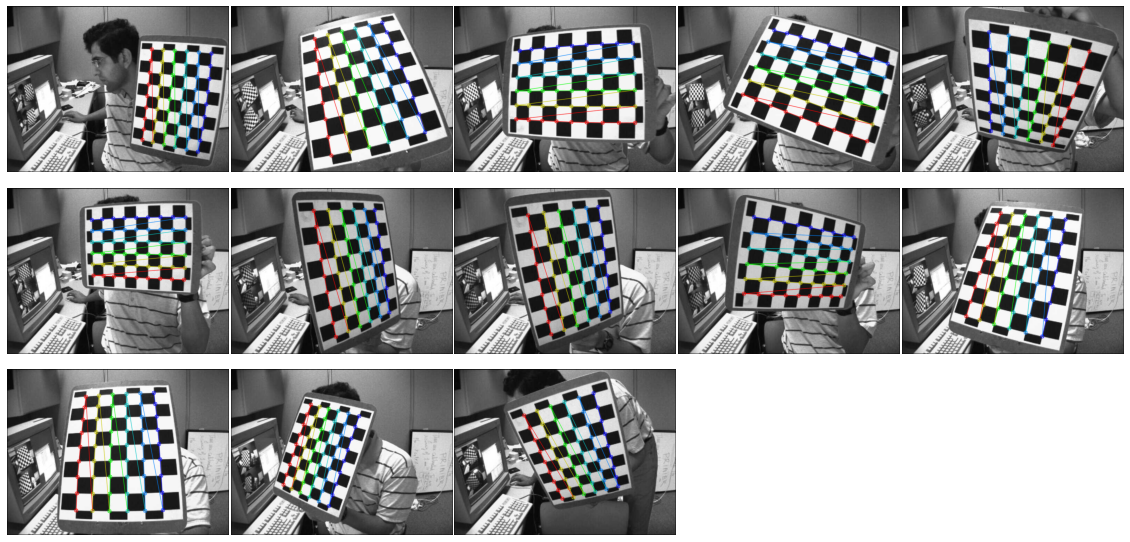

In [ ]:
# 이 부분은 수정하지 않습니다. 

from matplotlib.gridspec import  GridSpec
print(len(corner_imgs))

nrows = 3
ncols = 5

fig = plt.figure(figsize = (20,10))
grid = GridSpec(nrows, ncols, wspace=0.01, hspace=0.0)

for i, img in enumerate(corner_imgs) :
  ax = plt.subplot(grid[i])
  ax.axis('off')
  ax.imshow(img)

## Calibration 

찾은 코너 포인트를 이용해 카메라의 내부/외부 파라미터를 찾는다.

**과제** 

- 카메라 매트릭스와 회전/이동 벡터들을 구한다.

관련 함수 

- `cv.calibrateCamera`

In [ ]:
# To-do : cam_matrix, rotation_vectors, translation_vectors를 찾기
## 월드 좌표계의 코너점 좌표값들과 이미지에서 구한 각 코너점들의 좌표값을 입력하여 카메라 매트릭스와 회전/이동 벡터들을 구한다. 
retval, cam_matrix, distCoeffs, rotation_vectors, translation_vectors = cv.calibrateCamera(objectPoints=objpoints, imagePoints=imgpoints, 
                                                                                           imageSize=images[0].shape[:2], cameraMatrix=None, distCoeffs=None)

In [ ]:
# 이 부분은 수정하지 않습니다. 

print('camera matrix \n', cam_matrix)
print('rotation vectors \n', rotation_vectors)
print('translation vectors \n', translation_vectors)

camera matrix 
 [[536.06450601   0.         342.36862295]
 [  0.         536.00718097 235.53174146]
 [  0.           0.           1.        ]]
rotation vectors 
 [array([[0.40772955],
       [0.30385861],
       [1.64906233]]), array([[-0.29188897],
       [ 0.42830181],
       [ 1.31269937]]), array([[-0.11083264],
       [ 0.23974975],
       [-0.00213543]]), array([[-0.27697675],
       [ 0.18689508],
       [ 0.35483177]]), array([[ 0.41307563],
       [ 0.64936304],
       [-1.33719521]]), array([[0.16852561],
       [0.27575717],
       [0.0134676 ]]), array([[-0.41927252],
       [-0.49991988],
       [ 1.33555156]]), array([[-0.17021087],
       [-0.47138363],
       [ 1.34598873]]), array([[ 0.20289183],
       [-0.42414664],
       [ 0.13245584]]), array([[-0.09096166],
       [ 0.47966601],
       [ 1.75338366]]), array([[-0.23849939],
       [ 0.34777742],
       [ 1.53073674]]), array([[0.1794731 ],
       [0.34574366],
       [1.86847179]]), array([[ 0.4630177 ],
       [

**과제**

- 아래 링크를 참고하여 얻어낸 camera matrix, rotation and translation vector를 이용해 이미지 상에 3D 축을 그린다.
- https://docs.opencv.org/master/d7/d53/tutorial_py_pose.html

In [ ]:
# To-do

## 원점으로부터 각각의 축 방향으로 일정한 길이의 선분을 그려주는 함수를 정의한다.
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)
axis_imgs = []
for f in image_files :
  img = cv.imread(f)
  ret, corner, corner_img = findCorner(img)

  ## rotation vector와 translation vector를 구한다.
  retval, rotation_vectors, translation_vectors = cv.solvePnP(objectPoints=objp, imagePoints=corner, cameraMatrix=cam_matrix, distCoeffs=distCoeffs)
  
  ## 위에서 구한 cam_matrix, rotation vector, traslation vector를 사용하여 3D 상의 점을 이미지 평면에 투영시킨다.
  ## objectPoints에 axis를 넣은 것은 3D 축에 해당하는 점들을 2D 평면에 정사영시키기 위해서이다.
  imgpts, jac = cv.projectPoints(objectPoints=axis, rvec=rotation_vectors, tvec=translation_vectors, cameraMatrix=cam_matrix, distCoeffs=distCoeffs)

  axis_img = draw(corner_img, corner, imgpts)
  axis_imgs.append(axis_img)

13


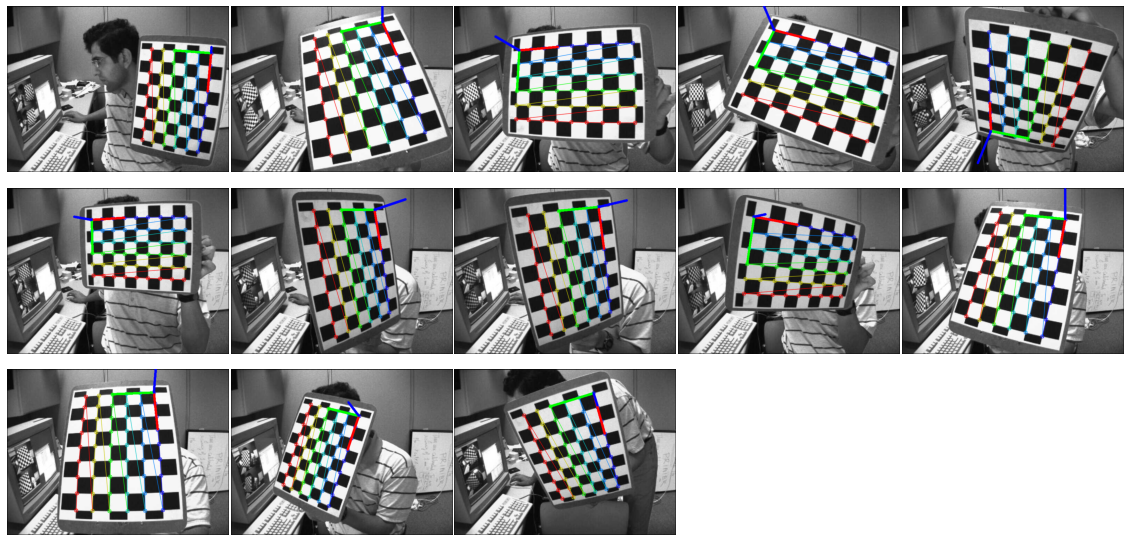

In [ ]:
from matplotlib.gridspec import  GridSpec
print(len(axis_imgs))

nrows = 3
ncols = 5

fig = plt.figure(figsize = (20,10))
grid = GridSpec(nrows, ncols, wspace=0.01, hspace=0.0)

for i, img in enumerate(axis_imgs) :
  ax = plt.subplot(grid[i])
  ax.axis('off')
  ax.imshow(img)

## 추가 점수 과제

직접 찍은 체스 보드 이미지를 사용해 위 과정을 똑같이 수행한다.
  - 체스 보드는 첨부된 이미지(pattern.png), 직접 그린/다운로드한 이미지 등을 출력해 사용한다.

# of images: 10


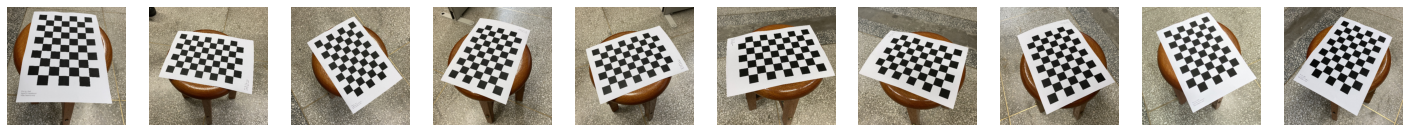

In [ ]:
image_files2 = glob.glob(ROOT + 'test*.jpg')
images2 = []
for f in image_files2:
  img = cv.imread(f)
  w = h = 480
  img = cv.resize(img, (w, h))
  # print(img.shape)
  images2.append(img)

print("# of images:", len(images2))

plt.figure(figsize=(25, 10))
for i, img in enumerate(images2):
  plt.subplot(1, len(images2), i + 1)
  plt.imshow(img[:, :, ::-1])
  plt.axis('off')
plt.show()

### 찾은 코너 시각화

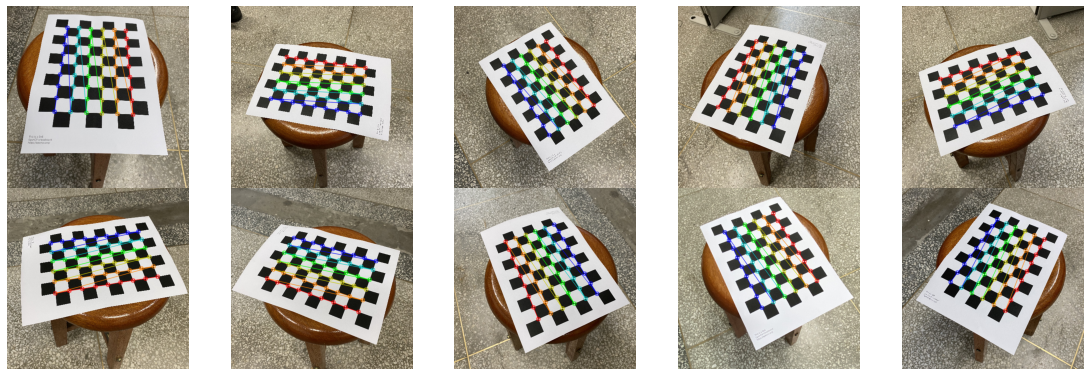

In [ ]:
objpoints = []
imgpoints = []
corner_imgs = []

fig = plt.figure(figsize=(20, 10))
grid = GridSpec(2, 5, wspace=0.01, hspace=0.0)
for i, img in enumerate(images2):
  ret, corner, corner_img = findCorner(img)

  if ret == True:
    objpoints.append(objp)
    imgpoints.append(corner)
    corner_imgs.append(corner_img)

    ax = plt.subplot(grid[i])
    ax.axis('off')
    ax.imshow(corner_img[:, :, ::-1])
plt.show()

### Calibration

In [ ]:
ret, cam_matrix, distCoeffs, rotation_vectors, translation_vectors = cv.calibrateCamera(objectPoints=objpoints, imagePoints=imgpoints, 
                                                                                        imageSize=images2[0].shape[:2], cameraMatrix=None, distCoeffs=None)

print('camera matrix \n', cam_matrix)
print('rotation vectors \n', rotation_vectors)
print('translation vectors \n', translation_vectors)

camera matrix 
 [[479.27956153   0.         238.85840809]
 [  0.         481.23832689 234.11098561]
 [  0.           0.           1.        ]]
rotation vectors 
 [array([[-0.48771938],
       [ 0.43035536],
       [ 1.55143364]]), array([[-0.52713832],
       [ 0.07788291],
       [ 0.18953182]]), array([[-0.28949493],
       [ 0.13030461],
       [ 0.98090817]]), array([[-0.50628201],
       [-0.27730675],
       [-1.16904075]]), array([[-0.50212073],
       [-0.07554621],
       [-0.37171735]]), array([[-0.11953465],
       [ 0.84018558],
       [ 2.83527878]]), array([[-0.22329806],
       [-0.76597064],
       [-2.65338202]]), array([[-0.35499919],
       [-0.48856306],
       [-1.93593148]]), array([[-0.39402576],
       [ 0.26811106],
       [ 1.08935647]]), array([[-0.34806315],
       [ 0.52551515],
       [ 2.02669942]])]
translation vectors 
 [array([[ 2.41037557],
       [-5.42816562],
       [16.08993188]]), array([[-3.56974154],
       [-3.86597456],
       [19.0824065 ]])

### camera matrix, rotation and translation vector를 이용해 이미지 상에 3D 축을 그린다.

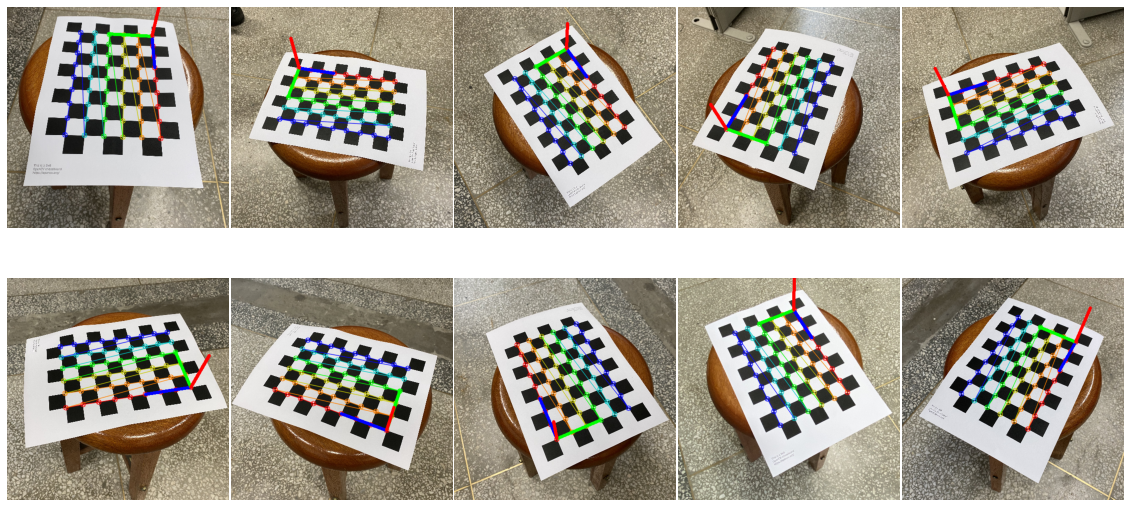

In [ ]:
axis2 = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)

fig = plt.figure(figsize = (20,10))
grid = GridSpec(2, 5, wspace=0.01, hspace=0.0)

for i, f in enumerate(image_files2):
  img = cv.imread(f)
  w = h = 480
  img = cv.resize(img, (w, h))
  ret, corner, corner_img = findCorner(img)
  retval, rotation_vectors, translation_vectors = cv.solvePnP(objectPoints=objp, imagePoints=corner, cameraMatrix=cam_matrix, distCoeffs=distCoeffs)
  imgpts, jac = cv.projectPoints(objectPoints=axis, rvec=rotation_vectors, tvec=translation_vectors, cameraMatrix=cam_matrix, distCoeffs=distCoeffs)
  axis_img = draw(corner_img, corner, imgpts)
  
  ax = plt.subplot(grid[i])
  ax.axis('off')
  ax.imshow(axis_img[:, :, ::-1])